In [1]:
# Imports 
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Cleaning import GetCleanedData

In [2]:
# Importing data
PATH = 'src'
header = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 
          'Movie languages', 'Movie country', 'Movie genres']
df = pd.read_csv(PATH + '/movie.metadata.tsv', sep='\t', names=header, skipinitialspace=True)


### Data Cleaning
After some data exploration we decided to clean the data. 
- Rows with missing Movie country, languages or genres were dropped
- Only the year of the movie release date was kept
- Only the first genre of a movie was kept

We saw that when we clean the rows that do not contain values of box office revenue the dataset is seriously reduced. Our idea was to keep a version of the dataset without taking care of the box office revenue when it is not the target of the analysis. We notice that the size difference between  df_date_revenue_clean and df_date_revenue_runtime_clean is negligeable, no need to treat them separately.

In [3]:
print("Data set initial size = ", df.size)
print("Number of NaN values for each columns:")
if df.isnull().values.any():
    print(df.isnull().sum())

Data set initial size =  735669
Number of NaN values for each columns:
Wikipedia movie ID              0
Freebase movie ID               0
Movie name                      0
Movie release date           6902
Movie box office revenue    73340
Movie runtime               20450
Movie languages                 0
Movie country                   0
Movie genres                    0
dtype: int64


In [4]:
df_date_clean, df_date_revenue_clean, df_date_revenue_runtime_clean = GetCleanedData(df)

print('Size of the data with the dates cleaned up : ', df_date_clean.size)
print('Size of the data with the dates and the box office revenues cleaned up : ', df_date_revenue_clean.size)
print('Size of the data with the dates, the box office revenues and the runtimes cleaned up : ', df_date_revenue_runtime_clean.size)

Size of the data with the dates cleaned up :  555507
Size of the data with the dates and the box office revenues cleaned up :  72207
Size of the data with the dates, the box office revenues and the runtimes cleaned up :  71838


In [5]:
df_date_revenue_runtime_clean.sample(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
28513,27382757,/m/0by18s2,Beyond a Reasonable Doubt,2009,3992844.0,106.0,[English Language],United States of America,Thriller
68847,171939,/m/01738w,Small Soldiers,1998,54682547.0,110.0,[English Language],United States of America,Science Fiction
58885,16839388,/m/0407yj_,Cars 2,2011,559852396.0,106.0,"[French Language, Japanese Language, Italian L...",United States of America,Adventure
16340,1032266,/m/03_zr8,Mozart and the Whale,2005,84447.0,94.0,[English Language],United States of America,Drama
22430,26396356,/m/04j11pt,The Killing Time,1987,500283.0,92.0,[English Language],United States of America,Thriller


### Cleaning df1

In [6]:
header2 = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date','Character Name', 'Actor DOB', 'Actor gender',
           'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age at movie release', 'Freebase character map']
df2 = pd.read_csv(PATH + '/character.metadata.tsv', sep='\t', index_col=False, names=header2, skipinitialspace=True, usecols=range(len(header2)))

In [7]:
df2.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


In [8]:
if df2.isnull().values.any():
    print(df2.isnull().sum())

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie release date              9995
Character Name                257875
Actor DOB                     106145
Actor gender                   45609
Actor height                  295845
Actor ethnicity               344611
Actor name                      1228
Actor age at movie release    158113
Freebase character map             0
dtype: int64


In [9]:
merged_df = pd.merge(df_date_clean, df2, on='Wikipedia movie ID', how='inner')

merged_df = merged_df.drop(columns=['Freebase movie ID_y', 'Movie release date_y'])

merged_df = merged_df.rename(columns={'Freebase movie ID_x': 'Freebase movie ID', 
                                      'Movie release date_x': 'Movie release date'})


In [10]:
if merged_df.isnull().values.any():
    print(merged_df.isnull().sum())

Wikipedia movie ID                 0
Freebase movie ID                  0
Movie name                         0
Movie release date                 0
Movie box office revenue      304688
Movie runtime                  34286
Movie languages                    0
Movie country                      0
Movie genres                       0
Character Name                220899
Actor DOB                      97409
Actor gender                   41620
Actor height                  264365
Actor ethnicity               309432
Actor name                      1100
Actor age at movie release    135641
Freebase character map             0
dtype: int64


In [11]:
count = 0
for i in range (len(merged_df)):
    if merged_df.iloc[i].duplicated().all():
        count+=1

print("Nb of duplicated row : ",count)

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\algorithms.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return htable.duplicated(values, keep=keep)


Nb of duplicated row :  0


In [12]:

# Supprimer les valeurs NaN de la colonne 'Movie release date'
merged_df = merged_df.dropna(subset=['Movie release date']).copy()

## Fonction pour compléter les dates partiellement formatées
#def complete_date(date):
#    if len(date) == 4:  # Si la date contient seulement l'année (format '%Y')
#        return date + "-01-01"  # Compléter avec le 1er janvier de l'année
#    elif len(date) == 7:  # Si la date contient l'année et le mois (format '%Y-%m')
#        return date + "-01"  # Compléter avec le 1er jour du mois
#    return date  # Si la date est déjà complète (format '%Y-%m-%d')

def format_date(date) :
    # Only taking movie release year
    date = date[:4]
    return date

# Appliquer la fonction pour compléter les dates partiellement formatées
merged_df.loc[:,'Movie release date'] = merged_df['Movie release date'].apply(format_date)

# Filtrer les dates qui sont en dehors de la plage valide (1677-2262)
def filter_out_of_bounds(date):
    try:
        # Tenter la conversion en datetime pour voir si elle est valide
        pd.to_datetime(date)
        return True  # Si la conversion réussit, la date est valide
    except pd.errors.OutOfBoundsDatetime:
        return False  # Si une erreur est levée, la date est hors limites

# Appliquer le filtre pour garder uniquement les dates dans la plage valide
merged_df = merged_df[merged_df['Movie release date'].apply(filter_out_of_bounds)]

# Convertir les dates restantes en format datetime
#merged_df['Movie release date'] = pd.to_datetime(merged_df['Movie release date'], format='%Y-%m-%d', errors='coerce')

min_date = merged_df['Movie release date'].min()
max_date = merged_df['Movie release date'].max()

print(min_date)
print(max_date)

1888
2015


In [13]:
merged_df.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres,Character Name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw
1,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m
2,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g
3,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6
4,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],United States of America,Thriller,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r


# Data Analysis

### 1) Dataset Exploration

In [14]:
df_date_clean.describe()

,Wikipedia movie ID,Movie box office revenue,Movie runtime
count,6.172300e+04,8.023000e+03,5.088400e+04
mean,1.539445e+07,4.964490e+07,1.161865e+02
std,1.067145e+07,1.141051e+08,4.784577e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,5.698346e+06,2.249000e+06,8.300000e+01
50%,1.399171e+07,1.144980e+07,9.400000e+01
75%,2.405106e+07,4.304346e+07,1.070000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In this analysis, we focus on the first 18 countries which produce the more movies

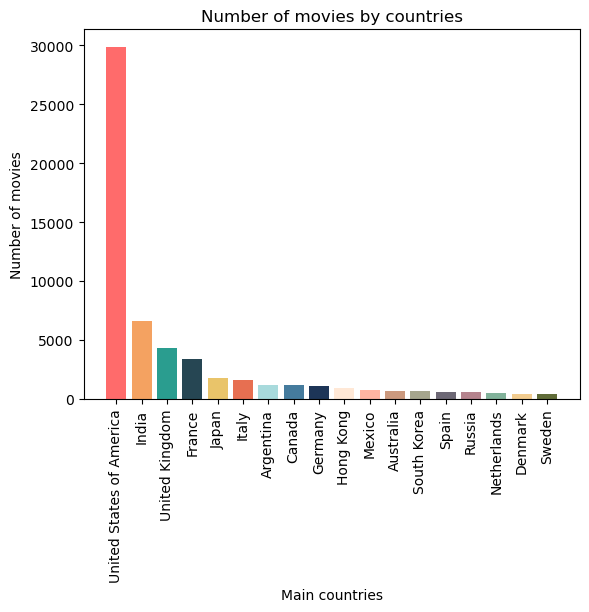

In [15]:
countries = df_date_clean.groupby(['Movie country']).count()['Wikipedia movie ID']

countries['Russia'] = countries['Russia'] + countries['Soviet Union']
countries['Germany'] = countries['Germany'] + countries['German Democratic Republic'] + countries['West Germany']
countries = countries.drop('Soviet Union')
countries = countries.nlargest(18)
countries_names = countries.index.to_list()

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]


plt.bar(countries_names,countries,width=0.8, color = colors)
plt.xticks(rotation=90)
plt.xlabel('Main countries')
plt.ylabel('Number of movies')
plt.title('Number of movies by countries')
plt.show()

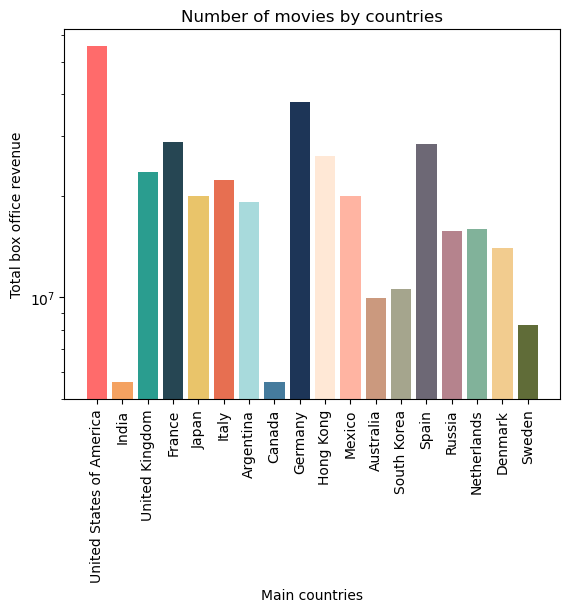

In [16]:
countries_revenues = df_date_revenue_clean.groupby(['Movie country'])['Movie box office revenue'].mean()
countries_revenues['Germany'] = (countries_revenues['Germany'] + countries_revenues['West Germany'])/2
countries_revenues = countries_revenues.drop('West Germany')
countries_revenues = countries_revenues[countries_names]



plt.bar(countries_names, countries_revenues, color = colors)
plt.yscale('log')
plt.xticks(rotation=90)
plt.xlabel('Main countries')
plt.ylabel('Total box office revenue')
plt.title('Number of movies by countries')
plt.show()

In this section, we will focus on the 6 diverse film producers and analyse their movie production over the years, starting from 1890 to 2016.

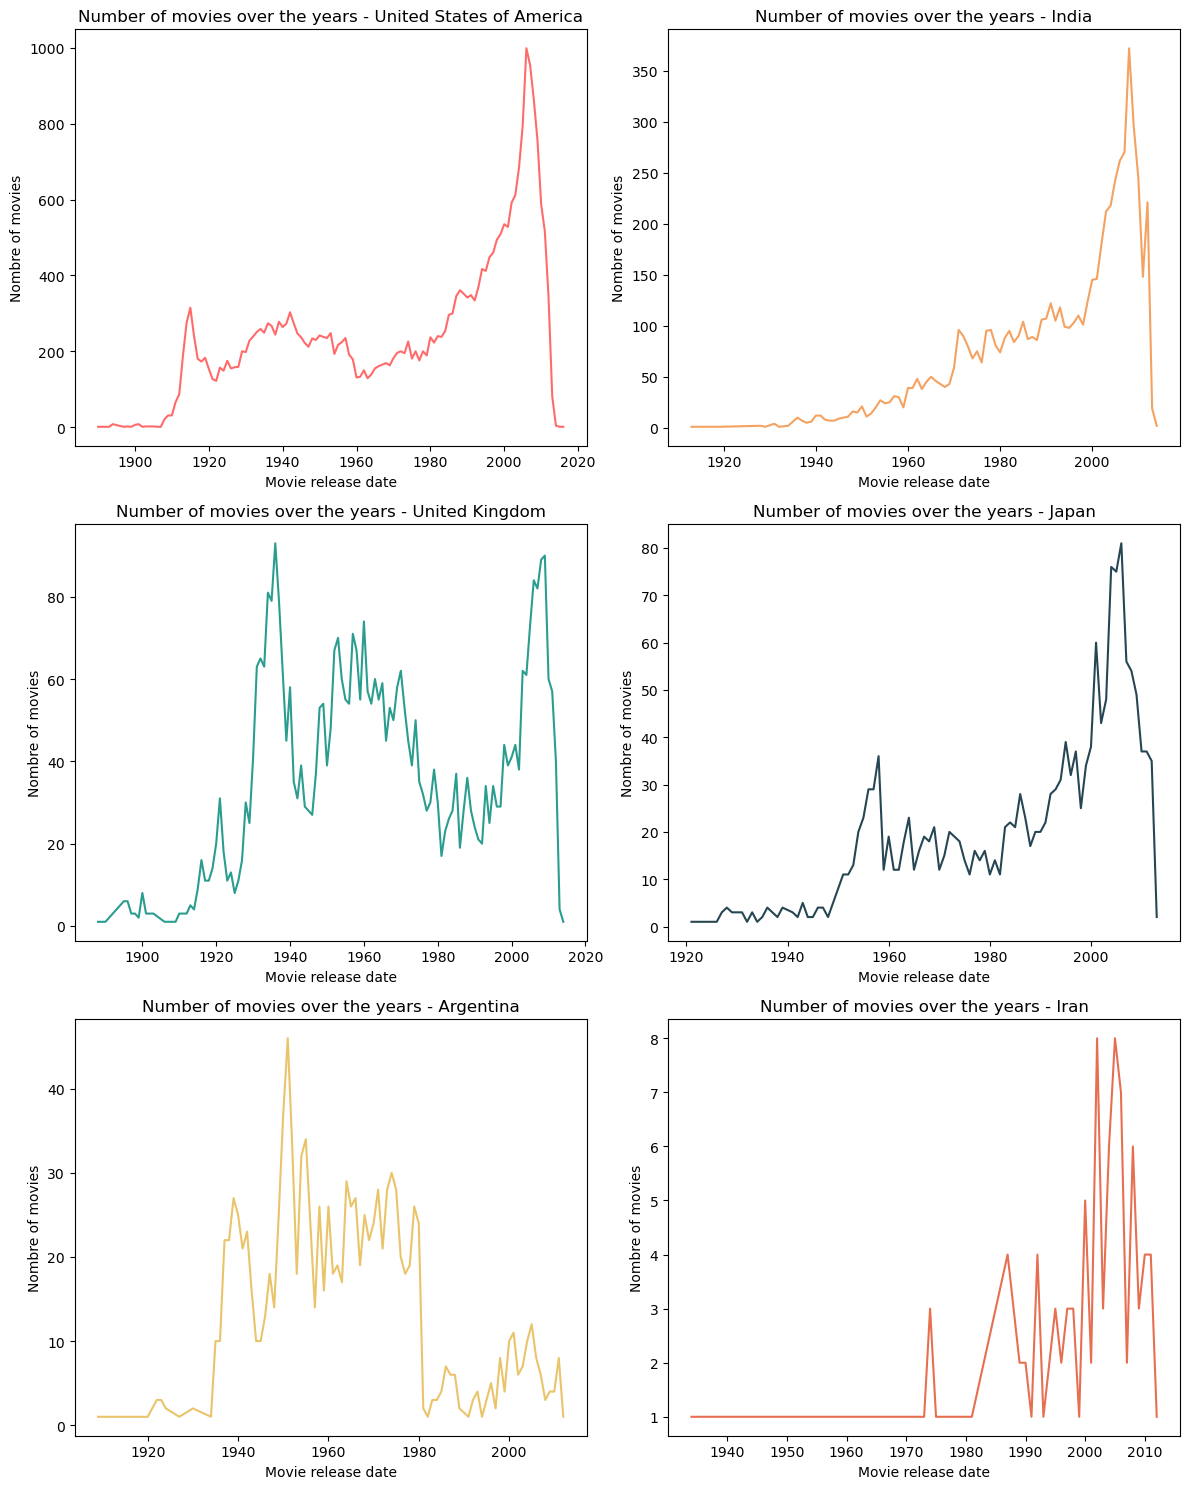

In [17]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']


df_focus = df_date_clean[df_date_clean['Movie country'].isin(focus_countries)]

nb_per_year = df_focus.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})

nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    country_data = nb_per_year[nb_per_year['Movie country'] == country]
    
    axes[idx].plot(country_data['Movie release date'], country_data['Movie count'], linestyle='-', color=colors[idx])
    axes[idx].set_title(f"Number of movies over the years - {country}")
    axes[idx].set_xlabel("Movie release date")
    axes[idx].set_ylabel("Nombre of movies")

plt.tight_layout()
plt.show()

The global trend that we see on the 6 graphs is an increase of the movie production between 1890 and 2007. We can interprate those result and estimate that the advancement of new technologies worldwide are the major cause of this increase.

We can observe a drop in the american movie production around 1915 which coincides with World War I. It did not really affected the UK because their movie production was very low at that time. India, Argentina, Iran and Japan was not involved in World War I. Concerning World War II the observation is a bit different. We notice a huge decrease of number of movie for the UK and Argentina around 1939-1945 and a less important one for the USA. UK and USA were directly involved in the World War II while Argentina had the influence of Germany and Italy. Moreover, the number of movies produced per yer before 1940 for Japan is very low but we can observe that this number increases a lot after World War II. 

Around 2007, we discern a fall of prodcution for the 6 countries. This date corresponds to the appearance of Netflix, a platform that offers a streaming service of movies, series. People can access to huge number of movies very easily without having to go to cinema theatres. 2008 economic crisis could also have an impact on this production of movies.

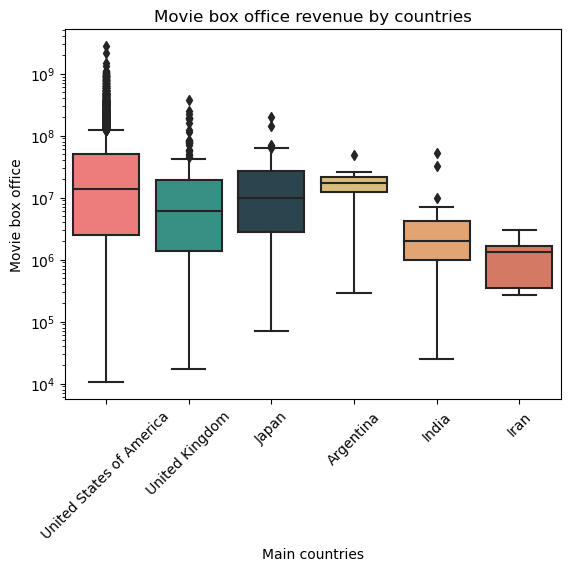

In [18]:
df_revenue_focus = df_date_revenue_clean[df_date_revenue_clean['Movie country'].isin(focus_countries)]

countries_revenues = df_revenue_focus.groupby(['Movie country'])['Movie box office revenue']

color_dict = dict(zip(focus_countries, colors))
sns.boxplot(x='Movie country', y='Movie box office revenue', data=df_revenue_focus, palette=color_dict)
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel('Main countries')
plt.ylabel('Movie box office')
plt.title('Movie box office revenue by countries')
plt.show()

India is the second country with the highest number of films produced however the boxplot shows that the movie box office revenue per film is lower than UK, Japan or Argentina even if these countries produce less films. 

USA is still the first country and there are a lot of outliers with a high movie box office revenue. 

Argentina is the 7 country with the highest nb of films produced, after USA, India, UK and Japan. However, we can observe that in mean, it has a highest movie box office revenue per film than these countries. It also has a lower difference between first and third quartile. However it has just one outliers with a abnormaly high movie box office revenue. 

Iran is the country with the lowest number of film produced and also, in average, the lowest movie box office revenue. Nonetheless, it has the lowest gap between whiskers meaning that the distribution of the box office revenue per film is consistent.

# Correlation

               Movie country  Total Movie Count
0                Afghanistan                  1
1                  Argentina                  7
2                  Australia                 57
3                    Austria                  5
4                    Belgium                  7
5                     Brazil                  5
6                   Bulgaria                  1
7                     Canada                 67
8                      China                  9
9             Czech Republic                  5
10                   Denmark                 11
11                   England                 10
12                   Finland                  9
13                    France                331
14                   Germany                 15
15                    Greece                  1
16                 Hong Kong                 46
17                   Hungary                  1
18                   Iceland                  2
19                     India            

<Axes: xlabel='Total Movie Count', ylabel='Total Box office revenue'>

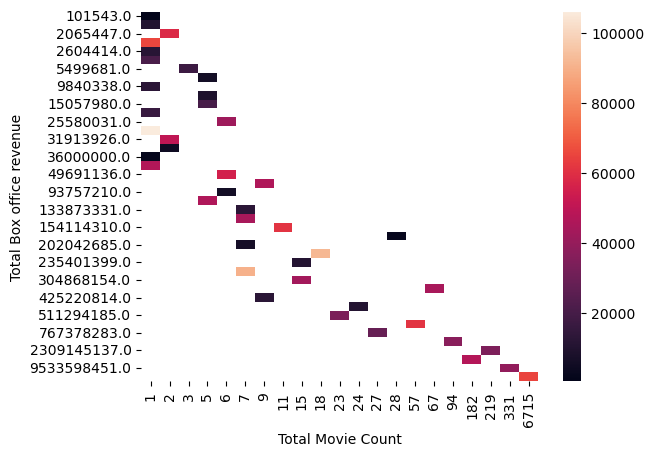

In [19]:
# HEATMAP # Nul, est-ce qu'on garde ?

df_gdp = pd.read_csv(PATH + '/GDP.csv', sep=';',)
#df_gdp = df_gdp[df_gdp['Country'].isin(focus_countries)]
df_gdp = df_gdp.rename(columns={"Country": "Movie country"})
#df_gdp['GDP per capita (constant US$)'] = pd.to_numeric(df_gdp['GDP per capita (constant US$)'], errors='coerce')

nb_per_year = df_date_revenue_clean.groupby(['Movie country', 'Movie release date']).count()['Wikipedia movie ID']
nb_per_year = nb_per_year.reset_index()
nb_per_year = nb_per_year.rename(columns={'Wikipedia movie ID': 'Movie count'})
nb_per_year['Movie release date'] = pd.to_datetime(nb_per_year['Movie release date'], errors='coerce')

total_films_per_country = nb_per_year.groupby('Movie country')['Movie count'].sum().reset_index()
total_films_per_country.columns = ['Movie country', 'Total Movie Count']
print(total_films_per_country)
df_correlation = pd.merge(df_gdp,total_films_per_country, on='Movie country')

total_revenue_per_country = df_date_revenue_clean.groupby('Movie country')['Movie box office revenue'].sum().reset_index()
total_revenue_per_country.columns = ['Movie country', 'Total Box office revenue']

df_correlation = pd.merge(df_correlation, total_revenue_per_country, on='Movie country')

df3 = pd.crosstab(
    df_correlation['Total Box office revenue'],
    df_correlation['Total Movie Count'],
    values=df_correlation['GDP per capita (constant US$)'],
    margins=False,
    aggfunc='mean'
)

sns.heatmap(df3, annot=False)



## Movie genres

In [20]:
focus_genres = ['Drama','Thriller','Comedy','Romance Film','Crime Fiction']

In [21]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']

dfs_countries = []
for country in focus_countries :
    df = df_date_clean[df_date_clean['Movie country'] == country]
    dfs_countries.append(df)

countries_grouped_genre = []

for df in dfs_countries :
    print(df)
    countries_grouped_genre.append(df.groupby(['Movie genres']).count()['Wikipedia movie ID'])



       Wikipedia movie ID Freebase movie ID  \
0                  975900         /m/03vyhn   
1                 3196793         /m/08yl5d   
5                13696889        /m/03cfc81   
7                10408933        /m/02qc0j7   
10                 175026         /m/017n1p   
...                   ...               ...   
81720             7761830         /m/0kvgqb   
81721            34474142        /m/0cpy07r   
81727            24209227        /m/07k5mlk   
81736            35228177        /m/0j7hxnt   
81738             9971909        /m/02pygw1   

                                              Movie name Movie release date  \
0                                         Ghosts of Mars               2001   
1      Getting Away with Murder: The JonBenét Ramsey ...               2000   
5                                          The Gangsters               1913   
7                               Alexander's Ragtime Band               1938   
10                                      

In [22]:
genres_data_by_country = []
for country_genres_nb in countries_grouped_genre :

    country_genres_nb['Romance Film'] = country_genres_nb['Romance Film'] + country_genres_nb.get('Romantic comedy', 0) + country_genres_nb.get('Romantic drama', 0)
    country_genres_nb['Action'] = country_genres_nb['Action'] + country_genres_nb.get('Action/Adventure', 0)
    country_genres_nb['Comedy'] = country_genres_nb['Comedy'] + country_genres_nb.get('Comedy film', 0)

    country_genres_nb = country_genres_nb[focus_genres]

    genres_data_by_country.append(country_genres_nb)



In [23]:
print(genres_data_by_country[0])

Movie genres
Drama            2289
Thriller         3594
Comedy            948
Romance Film     2780
Crime Fiction    2192
Name: Wikipedia movie ID, dtype: int64


In [24]:
import numpy as np

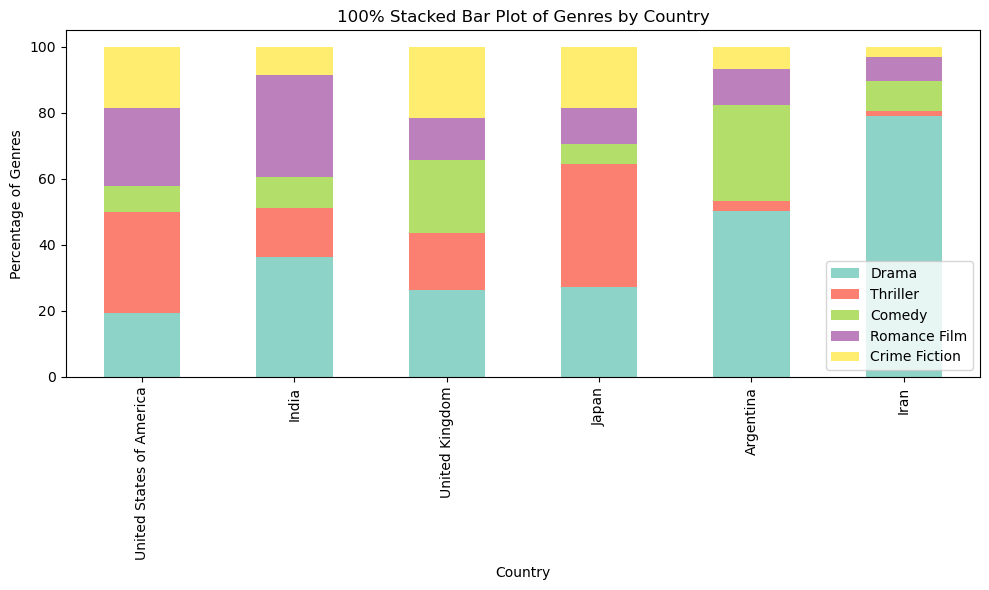

In [25]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

array_tot = []
for i in range(len(focus_countries)):
    v = [focus_countries[i]] + genres_data_by_country[i].values.tolist()
    array_tot.append(v)

df_tot = pd.DataFrame(array_tot, columns=['Countries'] + focus_genres)


df_normalized = df_tot.set_index('Countries')
df_normalized = df_normalized.div(df_normalized.sum(axis=1), axis=0) * 100


ax = df_normalized.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
ax.set_xlabel('Country')
ax.set_ylabel('Percentage of Genres')
ax.set_title('100% Stacked Bar Plot of Genres by Country')

plt.tight_layout()
plt.show()


================================================================================================

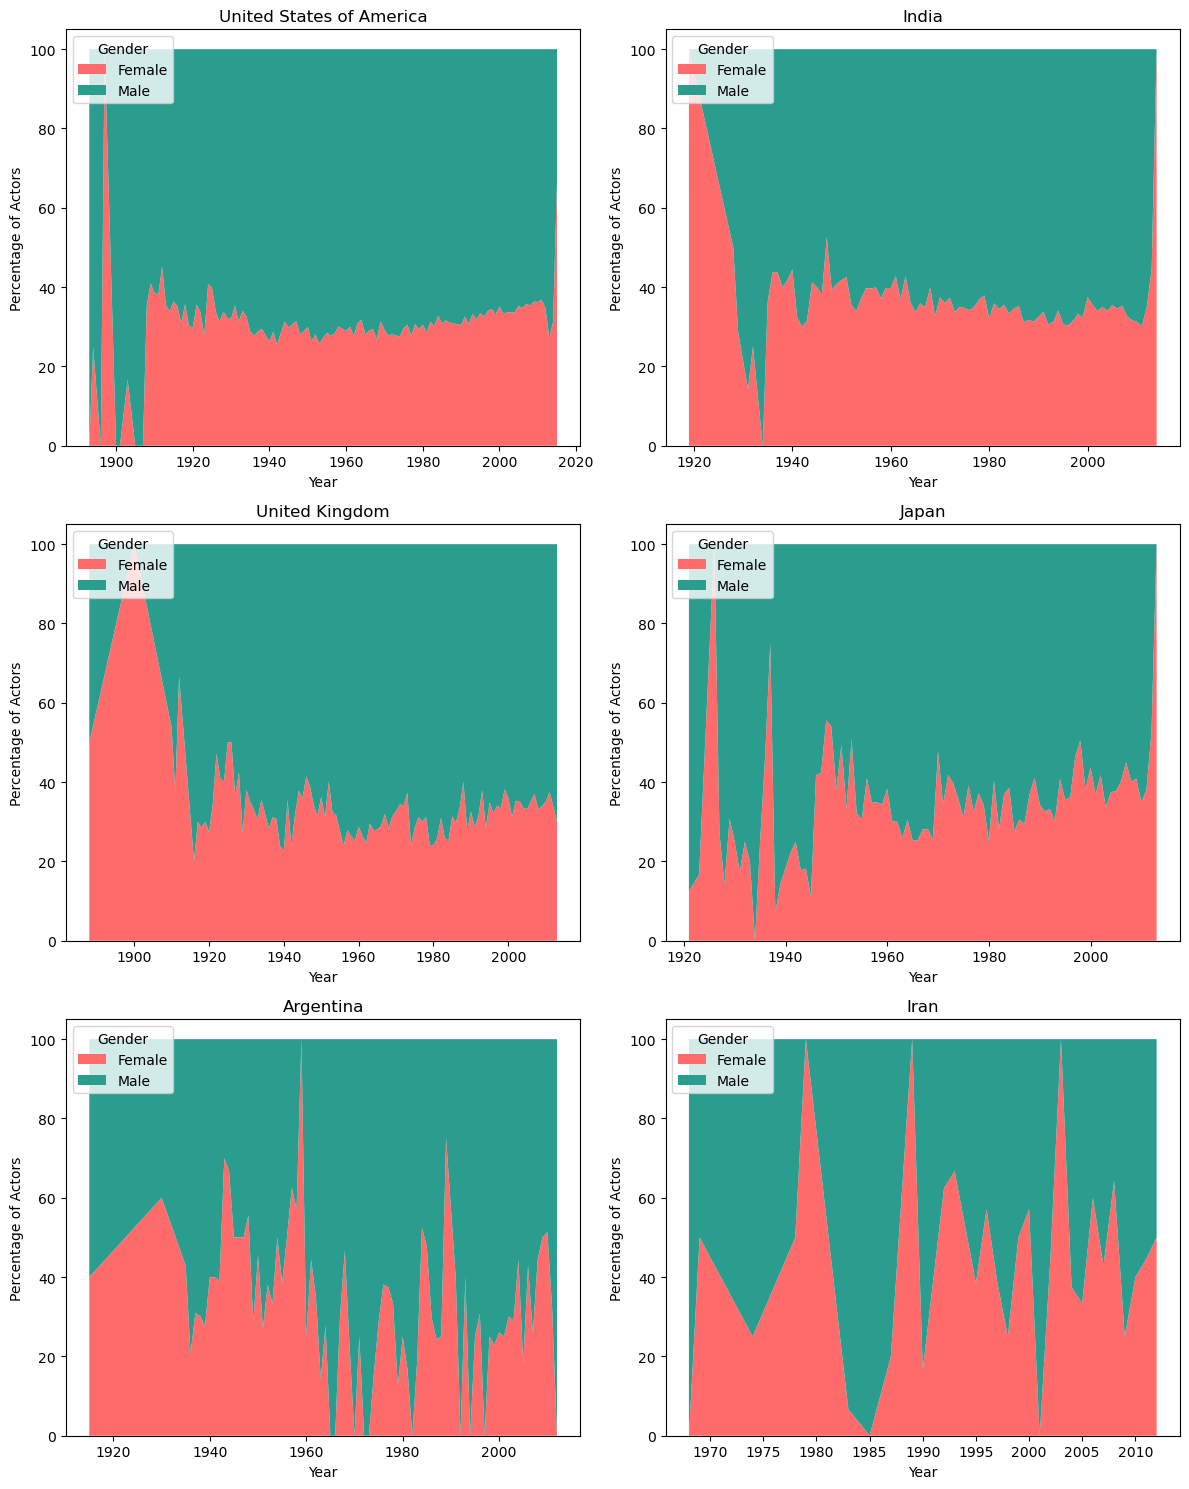

In [30]:
focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']


merged_df_focus = merged_df[merged_df['Movie country'].isin(focus_countries)]
actor_counts = merged_df_focus.groupby(['Movie release date', 'Movie country', 'Actor gender']).size().reset_index(name='Count')
total_counts = actor_counts.groupby(['Movie release date', 'Movie country'])['Count'].transform('sum')
actor_counts['Percentage'] = (actor_counts['Count'] / total_counts) * 100

actor_counts['Movie release date'] = pd.to_datetime(actor_counts['Movie release date'], errors='coerce')


num_rows, num_columns = 3, 2
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
axes = axes.flatten()  

# Plot for each country on a separate subplot
for i, country in enumerate(focus_countries):
    ax = axes[i]
    country_data = actor_counts[actor_counts['Movie country'] == country]  # Filter data for the country
    
    # Pivot data for stackplot: years as x, male/female percentages as y
    pivot_data = country_data.pivot(index='Movie release date', columns='Actor gender', values='Percentage').fillna(0)
    years = pivot_data.index
    male_percentage = pivot_data.get('M', 0)
    female_percentage = pivot_data.get('F', 0)
    
    # Plot the stackplot for male and female percentages
    ax.stackplot(years, female_percentage, male_percentage, labels=['Female', 'Male'], colors=["#FF6B6B", "#2A9D8F"])
    
    # Customize each subplot
    ax.set_title(f'{country}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage of Actors')
    ax.legend(loc='upper left', title='Gender')

plt.tight_layout()
plt.show()
